Imports

In [10]:
import torch,torchvision,torchinfo
from torch import nn
from torchvision import transforms
from going_modular import utils,data_setup,engine

1.Patch Creation:
The image is divided into N non-overlapping patches of size (P × P), where P is the predefined patch size. This results in a total of N = (H × W) / P² patches. Each patch is then flattened into a 1D vector of dimension (P² × C), producing a sequence of flattened patches with shape (N × (P² × C)).
2.Patch Embeddings:
Since the Transformer architecture requires a constant latent vector dimension D across all layers, the flattened patches are projected into a D-dimensional space using a trainable linear transformation . This linear projection learns to encode the patches into a suitable representation for the Transformer. The output of this projection is referred to as the patch embeddings, which serve as the input tokens for the subsequent Transformer encoder.
Mathematically:

Hybrid Architecture: Using CNN Features Instead of Image Patches

Instead of splitting the image directly into patches, ViT can also work with feature maps from a Convolutional Neural Network (CNN). Here’s how it works:

CNN Feature Maps as Input:
Instead of feeding raw image patches into the Transformer, we first pass the image through a CNN (like ResNet).
The CNN extracts useful features, producing a feature map (a grid of high-level image representations).
Patch Extraction from Feature Maps:
We then split this feature map into smaller patches, just like with raw images.
Alternatively, if we use 1×1 patches, it means we treat each point in the feature map as a separate "patch."
These patches are flattened and projected into the Transformer’s input dimension using a trainable linear layer (same as in standard ViT).
Adding Position and Class Tokens:
Just like in the original ViT, we add:
A [class] token (for classification).
Position embeddings (to keep track of spatial information).
The resulting sequence is then fed into the Transformer.
Why Use a Hybrid Model?

CNNs are good at capturing local patterns early on, which can help the Transformer focus on higher-level relationships.
This approach can be useful when working with images where low-level features (edges, textures) are important before applying global attention.

Model Configuration: ViT Base Variant

We implement the second variant (ViT-Base) from the original ViT paper [Dosovitskiy et al., 2020]](https://arxiv.org/pdf/2010.11929), with the following specifications (Table 1, Page 5):

Hyperparameter	ViT-Base (Our Choice)
Layers (L)	24
Hidden Size (D)	1024
MLP Size (D_{mlp})	4096
Heads (H)	16
Params	307M


In [39]:
# 1. Create a class which subclasses nn.Module
class ViTImageToPatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=1024):
        super().__init__()
        self.patch_size = patch_size
        # 3. Create a layer to turn an image into patches
        self.patcher_mapper = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,end_dim=3) # only flatten the feature map dimensions into a single vector(0th index is batch_size,1st index is embedding_dimension which is 1024 in our case,remain 2 dimensions is dimensions which we need to flat(this 2 dimension is number of pathces along width and length).)                   

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched_mapped = self.patcher_mapper(x) ##x_patched shape is (H/P,W/P,embedding_dim)
        x_flattened = self.flatten(x_patched_mapped)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

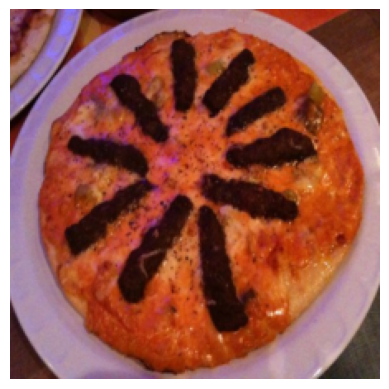

In [41]:
###example of converting image to patch image
from pathlib import Path
from PIL import Image
import random
from matplotlib import pyplot as plt

torch.manual_seed(0)
random.seed(0)

IMAGE_SIZE = 224


image_path = Path("data/pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"

#take all possible image paths from training dataset to randomly choose one of them 
images_paths = list(train_dir.glob("*/*.jpg"))
images_paths

random_image_path = random.sample(images_paths,k = 1)

image = Image.open(random_image_path[0])
class_name = random_image_path[0].parent.name

###convert image to torch Tensor and Resize it
transform = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                transforms.ToTensor()])

image:torch.Tensor = transform(image)
###now we already have path of image but to show it using matplotlib imshow we need to permute dimensions to see correct image
image_permuted = image.permute(1,2,0)
plt.imshow(image_permuted)
plt.axis(False)

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


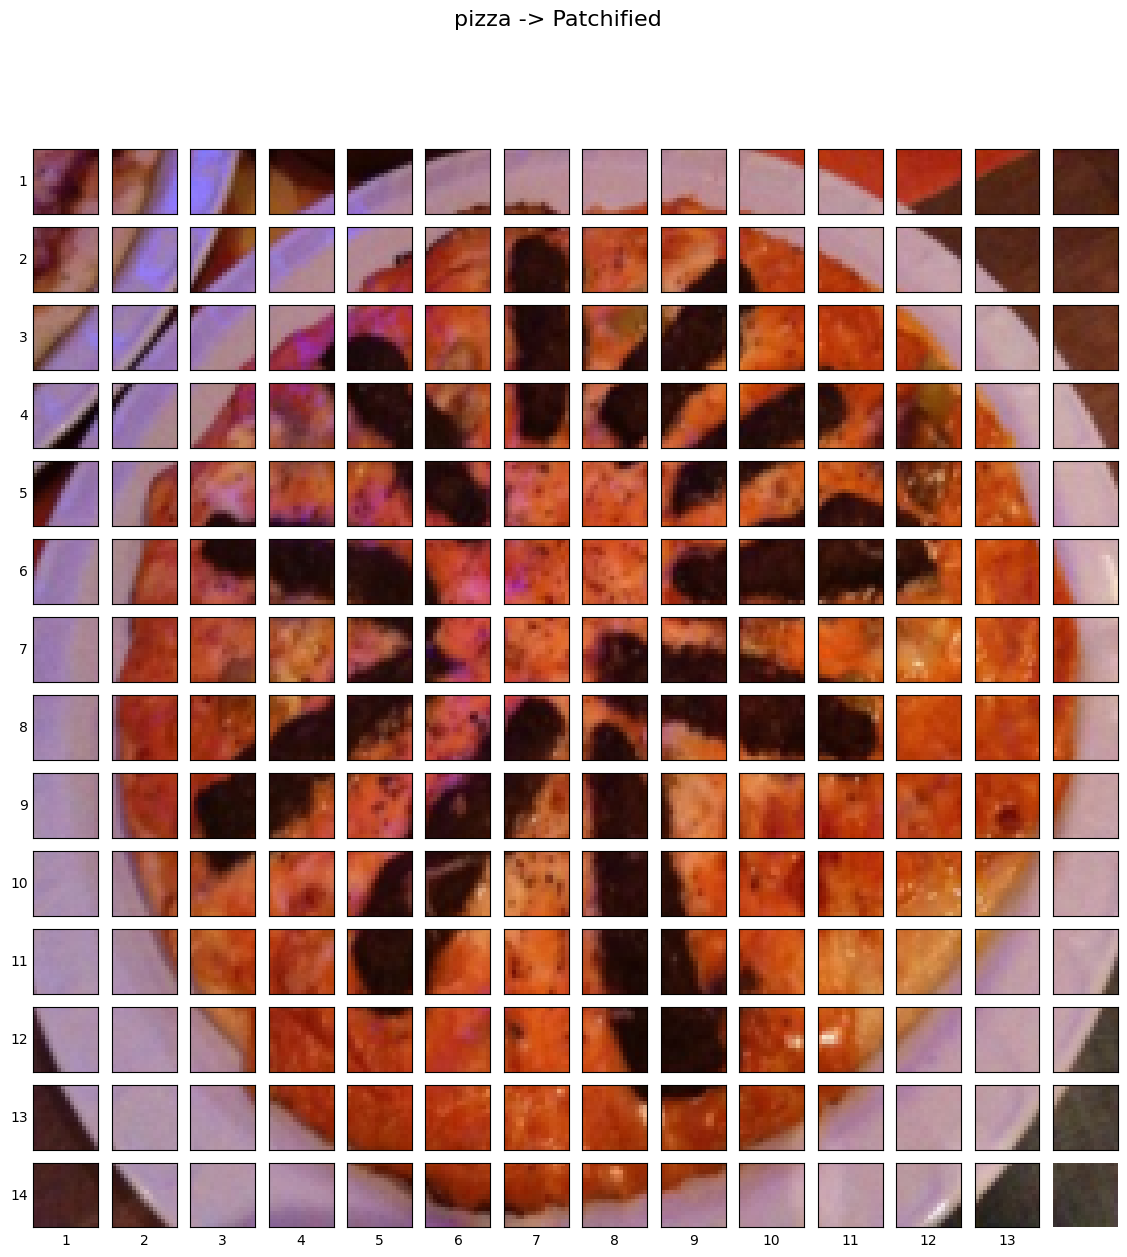

In [44]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
PATCH_SIZE = 16
num_patches = IMAGE_SIZE/PATCH_SIZE
assert IMAGE_SIZE % PATCH_SIZE == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {PATCH_SIZE} pixels x {PATCH_SIZE} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=IMAGE_SIZE // PATCH_SIZE, # need int not float
                        ncols=IMAGE_SIZE // PATCH_SIZE,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, IMAGE_SIZE, PATCH_SIZE)): # iterate through height
    for j, patch_width in enumerate(range(0, IMAGE_SIZE, PATCH_SIZE)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+PATCH_SIZE, # iterate through height
                                        patch_width:patch_width+PATCH_SIZE, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_name} -> Patchified", fontsize=16)
plt.axis(False)
plt.show()

In [40]:

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = ViTImageToPatchEmbedding(patch_size=patch_size)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Concatenate class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 1024])
Class token embedding shape: torch.Size([1, 1, 1024])
Patch embedding with class token shape: torch.Size([1, 197, 1024])
Patch and position embedding shape: torch.Size([1, 197, 1024])


I think here we end implementation first part of documentation(first equation:making image_embeddings from image).next step will be creating multi head self-attention layers...